# 项目简介

## 业务背景

下图是火花课堂的屏幕截图。在上课过程中，如果老师发现学生卡住了（或者学生告诉老师自己不能看到老师或无法操作课件），就会向技术支持提交一个**网络状况**工单。

![Alt text](screen_shot.png)


技术支持在看到这个工单后，会通过监课界面以学生视角观看课堂；如果技术支持认为*当时*学生课堂正常，就会关闭工单，并将关闭原因标注为“轻微抖动不影响上课”；否则，技术支持就会打电话给家长协助解决网络问题，并将关闭原因标注为“网络卡顿”。

前端开发告诉你，除了网络状况外，设备型号和性能也会导致操作卡顿；例如早期iPad或者低端Android运行火花课堂时也会卡顿。同时，他们也告诉你技术支持的关闭原因填写有噪音：用户当时是否卡，完全取决于技术支持监课的时机。

现在产研试图降低网络工单率。产品经理提出的一个建议是，**如果在工单提交时可以预测网络工单的关闭原因**，那么就可以在老师提交工单时在后台直接关闭预测为“轻微抖动不影响上课”的工单，而仅放行“网络卡顿”的工单。

你的同事也为你提取了一些正常课堂的数据，用作训练使用。


## 数据字典

type是你的Y数据：
- 0表示正常课堂
- 1表示产生网络工单且关闭原因为“轻微抖动不影响上课”
- 2表示产生网路工单且关闭原因为“网络卡顿”


火花课堂监控两张网络的状态。一张网络是声网，火花用它来传输音频和视频；另一张网络是game server，火花用它来传输师生间课件控制的数据。

声网的监控数据包括

- duration：通话时长，单位为秒，累计值；重置链接后清零。
- txAudioKBitrate:音频发送码率 (Kbps)，瞬时值
- rxAudioKBitrate:音频接收码率 (Kbps)，瞬时值
- txVideoKBitrate:音频发送码率 (Kbps)，瞬时值
- rxVideoKBitrate:音频接收码率 (Kbps)，瞬时值
- cpuTotalUsage:当前系统的 CPU 使用率 (%)
- cpuAppUsage:当前 App 的 CPU 使用率 (%)
- userCount: 当前频道内的用户人数
- sentFrameRate: 不重要
- sentBitrate: 不重要

客户端的game server的监控数据包括

- cpu: 上报数列的最高值
- lag: 客户端与game server的ping值
- fps: 客户端的针率
- memory_free：客户端未使用
- memory_app_used
- memory_inactive:

你的同事已经帮你把工单提交前40次监控和工单提交后40次监控的数据整理好了。X_lead_Y表示性能变量X在工单提交前Y次监控的数据；X_lag_Y表示性能变量X在工单提交后Y次监控的数据。X_lead_1和X_lag_1是最接近工单提交的数据。

此外，当性能数据在日志服务器上缺失时，统一填入-999

# 任务要求

## 建模

结合上述业务场景和产品需求，利用data.csv的数据，构建一个预测工单关闭原因的模型，并向产品经理和前端研发提交一个使用这个模型的产品方案。

## 汇报

在这个notebook中撰写你的报告（你也可以使用Rmarkdown）。并将你的代码也放在这个notebook中

然后向[这个Github项目](https://github.com/junchenfeng/huohua_hire)提交一个Pull Request

## 考核方面

我们考察

- 使用python生态进行数据建模的能力
- 将数据模型转化为业务生产力的能力
- 代码风格

祝你成功！

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.impute import SimpleImputer
import pydot
import matplotlib.pyplot as plt
from six import StringIO
import toad

dataDF = pd.read_csv("data.csv")

#type=0 正常数据（可能包含部分“轻微抖动不影响上课”数据，但是这部分客户承受能力较好，没有选择提交工单）
#type=2  经过客户和技术人员双重筛选，大概率是卡顿事例
#type=1 可能包括“轻微抖动”，也可能是卡顿，只不过技术支持核查的时候恰好正常了，也可能包含了客户误操作
#相对来说，type=0和type=2的数据更干净，而且我们只需要分辨是否卡顿，所以我们只使用“type=0” 和“type=2”的数据建模
dataDF = dataDF.query("type != 1")

#由于我们要预测的是工单提交时网络工单的关闭原因，所以只使用X_lead_Y的数据
#当然,也可以将“type=0”中的X_lag_Y数据拿出来，构造正常课堂数据，但是由于我们“type=0”的数据已经足够多了，所以不进行此操作
#由于sentFrameRate，sentBitrate不重要，故删除这些数据
dataDF = dataDF[[column for column in dataDF.columns if "_lead_" in column and "sent" not in column] + ["type"]]

#为了符合正常习惯，将type中的2修改为1
dataDF["type"] = dataDF["type"].replace(2, 1)

dataDF

,txAudioKBitrate_lead_1,txAudioKBitrate_lead_2,txAudioKBitrate_lead_3,txAudioKBitrate_lead_4,txAudioKBitrate_lead_5,txAudioKBitrate_lead_6,txAudioKBitrate_lead_7,txAudioKBitrate_lead_8,txAudioKBitrate_lead_9,txAudioKBitrate_lead_10,...,memory_inactive_lead_32,memory_inactive_lead_33,memory_inactive_lead_34,memory_inactive_lead_35,memory_inactive_lead_36,memory_inactive_lead_37,memory_inactive_lead_38,memory_inactive_lead_39,memory_inactive_lead_40,type
0,54,53.0,53.0,54.0,53.0,53.0,53.0,52.0,54.0,54.0,...,520306688.0,520241152.0,520241152.0,520290304.0,519831552.0,519503872.0,519421952.0,521404416.0,521666560.0,0
1,54,53.0,53.0,53.0,54.0,53.0,53.0,53.0,53.0,53.0,...,613957632.0,615907328.0,617185280.0,615677952.0,601047040.0,632061952.0,631521280.0,631734272.0,631848960.0,0
2,53,53.0,53.0,53.0,52.0,53.0,53.0,53.0,53.0,54.0,...,661536768.0,661684224.0,658587648.0,658423808.0,657178624.0,657866752.0,658063360.0,658620416.0,641826816.0,0
3,53,53.0,52.0,54.0,54.0,53.0,52.0,54.0,52.0,53.0,...,-999.0,548913152.0,-999.0,550371328.0,-999.0,549027840.0,-999.0,548782080.0,-999.0,0
4,53,12.0,53.0,54.0,51.0,43.0,42.0,47.0,53.0,53.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,43,46.0,53.0,53.0,53.0,53.0,51.0,53.0,53.0,53.0,...,302120960.0,302153728.0,302104576.0,301989888.0,301989888.0,302006272.0,302104576.0,302120960.0,302235648.0,0
4995,52,54.0,53.0,53.0,53.0,53.0,52.0,53.0,53.0,52.0,...,677576704.0,677904384.0,679346176.0,679378944.0,670416896.0,668876800.0,677183488.0,677085184.0,676921344.0,0
4996,52,53.0,54.0,53.0,52.0,53.0,53.0,53.0,52.0,53.0,...,616120320.0,615415808.0,615432192.0,615743488.0,615759872.0,615792640.0,617463808.0,617218048.0,618217472.0,0
4998,35,35.0,45.0,39.0,39.0,39.0,35.0,35.0,63.0,36.0,...,577388544.0,580845568.0,578945024.0,575782912.0,576045056.0,574537728.0,574406656.0,580894720.0,579878912.0,1


In [2]:
#检查数据发现，数据中依然存在未被填充的缺失值
#检查数据发现，-999只代表缺失值，不存在本身就是-999的数据
#为了进一步检查，将-999转换为np.nan
dataDF = dataDF.replace(-999, np.nan)

#由于X_lead_1是最接近于工单提交时的数据，我们有理由认为，编号越接近于1，对type的预测能力越强，经过分箱之后计算IV，证明了这一点
#所以下面建模的时候，只保留了lead_1的数据
#尝试保留多个时间点数据，如1-5，结果未见改善，故不采用
#尝试计算新的特征，如1-5的平均值，标准差，标准差/平均值等，结果未见改善，故不采用
#尝试计算发送码率与接收码率的差值，结果未见改善，故不采用
dataDF = dataDF[[column for column in dataDF.columns if re.search("_1$", column)] + ["type"]]

#检查不同type包含的缺失值，注意此时type=2被替换为了1
print(dataDF.query("type == 0").shape)
print(dataDF.query("type == 1").shape)
print(dataDF.query("type == 0").isnull().sum().sum())
print(dataDF.query("type == 1").isnull().sum().sum())

(3944, 15)
(668, 15)
118
42


In [3]:
#进一步检查缺失值，只能看出来对于部分特征，如“txAudioKBitrate”，卡顿事例更容易出现缺失值
#值得注意的是很多特征，type=0的约4000条数据与type=1的约700条数据具有相同个数的缺失值，不确定是什么因素造成的？
for column in dataDF.columns[:-1]:
    data_temp = dataDF[[column, "type"]]
    print(column,"\t",data_temp.query("type == 0").isnull().sum().sum(), data_temp.query("type == 1").isnull().sum().sum())
    
#进行缺失值中位数填充
#尝试了进行constant填充，对结果无明显改善
ins = SimpleImputer(strategy = 'median')
dataDF[:] = ins.fit_transform(dataDF[:])

#删除相关性较大的特征
print(dataDF.shape)
dataDF = toad.selection.select(dataDF, target = "type", corr = 0.6)
print(dataDF.shape)

txAudioKBitrate_lead_1 	 3 3
cpuTotalUsage_lead_1 	 0 0
rxAudioKBitrate_lead_1 	 3 3
cpuAppUsage_lead_1 	 0 0
txVideoKBitrate_lead_1 	 3 3
duration_lead_1 	 0 0
userCount_lead_1 	 3 3
rxVideoKBitrate_lead_1 	 3 3
cpu_lead_1 	 0 0
lag_lead_1 	 0 0
fps_lead_1 	 0 0
memory_free_lead_1 	 33 8
memory_app_used_lead_1 	 33 8
memory_inactive_lead_1 	 37 11
(4612, 15)
(4612, 14)


0.9356936416184971
[[1150   32]
 [  57  145]]
[0.         0.01522843 0.02707276 0.03976311 1.        ] 
 [0.         0.54950495 0.71782178 0.73267327 1.        ] 
 [1.82461538 0.82461538 0.5952381  0.27906977 0.04059985]


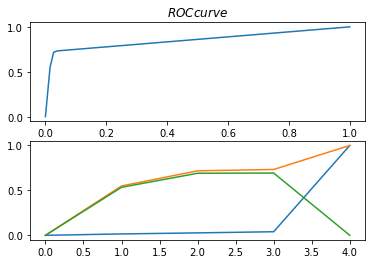

In [4]:
#按7：3划分训练集测试集
X_train, X_test, y_train, y_test = train_test_split(dataDF.iloc[:,dataDF.columns != "type"], dataDF["type"], test_size = 0.3)

#该场景可以用KNN，决策树以及集成学习（如XGBoost，LightGBM）建模
#但是由于最后要预测卡顿原因，所以选择决策树建模，其解释性更好，效率也更高
model = tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = 5, min_samples_split = 30, min_samples_leaf = 10, max_leaf_nodes = 10, min_impurity_decrease = 0.005)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#打印模型的accuracy和混淆矩阵
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

#画出ROC曲线，以及TPR,FPR曲线
y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score) 
print(fpr, "\n", tpr, "\n", thresholds)
plt.figure()
plt.subplot(211)
plt.plot(fpr, tpr)
plt.title('$ROC curve$')
plt.subplot(212)
plt.plot(range(len(fpr)), fpr)
plt.plot(range(len(fpr)), tpr)
plt.plot(range(len(fpr)), tpr - fpr)

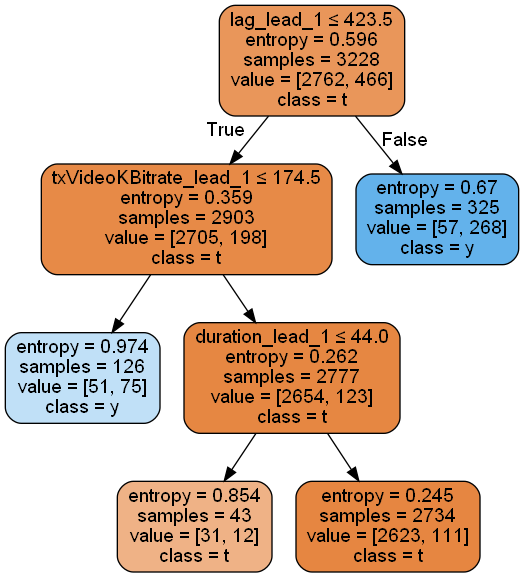

In [5]:
#此时KS最大值约为0.7
#可视化得到的决策树
dot_data = StringIO()
tree.export_graphviz(model, out_file=dot_data, feature_names=X_test.columns, class_names="type", filled=True, rounded=True, special_characters=True)
(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())
from IPython.display import Image
Image(graph.create_png())

In [6]:
#运行多次，模型较为稳定
#当有一个报告卡顿的工单进来时，若lag_lead_1比较大，则预测可能是由lag_lead 引起的
#如果不够大，且txVideoKBitrate_lead_1足够小，那预测是由txVideoKBitrate_lead造成的
#此时数据量还不够大，很难预测出所有原因，后期加大数据量，叶子节点可以继续分裂，应该会得到更好的结果